In [1]:
import os
import json
from pathlib import Path
from collections import defaultdict
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import textwrap

In [2]:
data_dir = Path('data')
# Create a nested defaultdict structure with three levels
traces_by_task = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

In [3]:
# List of valid error types we want to keep
valid_errors = {
    'enverror', 'keyerror', '\nruntimeerror', 
    'assertionerror', '\nvalueerror', 'syntaxerror', '\nimporterror',
    '\nattributeerror', 'outofmemoryerror', 'typeerror'
}

In [4]:
def is_actual_error(observation):
    # Ignore any error words that appear within backticks or double quotes
    # First remove text between backticks
    cleaned_text = re.sub(r'`[^`]*`', '', observation)
    # Then remove text between double quotes
    cleaned_text = re.sub(r'"[^"]*"', '', cleaned_text)
    
    # Check if the cleaned text contains any of our valid error types
    cleaned_text = cleaned_text.lower()
    return any(error in cleaned_text for error in valid_errors)

In [5]:
for trace_file in data_dir.rglob('env_log/trace.json'):
    try:
        with open(trace_file, 'r') as f:
            trace_data = json.load(f)
        
        path_parts = trace_file.parts
        task_name = path_parts[1]
        model_name = path_parts[2]
        iteration = path_parts[3]
        
        error_observations = []
        total_steps = len(trace_data['steps'])
        execute_script_steps = 0
        non_execute_script_steps = 0
        
        for step_num, step in enumerate(trace_data['steps'], 1):
            observation = step['observation']
            action_name = step['action']['name']
            
            # Count execute vs non-execute steps
            if action_name == "Execute Script":
                execute_script_steps += 1
            else:
                non_execute_script_steps += 1
            
            if is_actual_error(observation):
                error_observations.append({
                    'step': step_num,
                    'action': action_name,
                    'observation': observation
                })
        
        # Only store if we found valid errors
        if error_observations:
            traces_by_task[task_name][model_name][iteration] = {
                'error_observations': error_observations,
                'total_steps': total_steps,
                'execute_script_steps': execute_script_steps,
                'non_execute_script_steps': non_execute_script_steps
            }
        
    except json.JSONDecodeError as e:
        print(f"Error reading {trace_file}: {e}")

In [6]:
# Convert defaultdict to regular dict for JSON serialization
traces_dict = json.loads(json.dumps(traces_by_task))

# Save to JSON file with nice formatting
with open('error_analysis.json', 'w') as f:
    json.dump(traces_dict, f, indent=2)

# Print summary
print("\nSummary of error analysis:")
total_errors = 0
for task_name, models in traces_dict.items():
    print(f"\nTask: {task_name}")
    task_errors = 0
    for model_name, iterations in models.items():
        model_errors = sum(len(data['error_observations']) for data in iterations.values())
        task_errors += model_errors
        print(f"  Model: {model_name}")
        print(f"  Errors: {model_errors}")
    total_errors += task_errors
    print(f"  Total task errors: {task_errors}")
print(f"\nTotal errors across all tasks: {total_errors}")


Summary of error analysis:

Task: machine_unlearning
  Model: claude-3-5-sonnet-v2
  Errors: 51
  Total task errors: 51

Task: meta-learning
  Model: claude-3-5-sonnet-v2
  Errors: 30
  Total task errors: 30

Task: llm-merging
  Model: claude-3-5-sonnet-v2
  Errors: 16
  Total task errors: 16

Task: backdoor-trigger-recovery
  Model: claude-3-5-sonnet-v2
  Errors: 27
  Total task errors: 27

Task: perception_temporal_action_loc
  Model: claude-3-5-sonnet-v2
  Errors: 30
  Total task errors: 30

Total errors across all tasks: 154


In [44]:
##############################################################
## EnvError: submission didn't match the leaderboard records, file does not exist, incorrect argument passing (All Hallucination error mode)
## keyerror: passing incorrect argument names/not registering methods (Hallucination error mode)
## valueerror: Invalid learning rate, empty parameter list (Hallucination error mode)
## typeerror: unexpected keyword argument (Hallucination error mode)
## assertionerror: shape doesn't match, not divisible (Hallucination error mode)
## runtimeerror: tensor shape issues (Hallucination error mode)
## attributeerror: no attribute (Hallucination error mode)
## outofmemoryerror: CUDA out of memory
## importerror: cannot import (Hallucination error mode)
## syntaxerror: invalid syntax forgetting comma (Hallucination error mode)
##############################################################

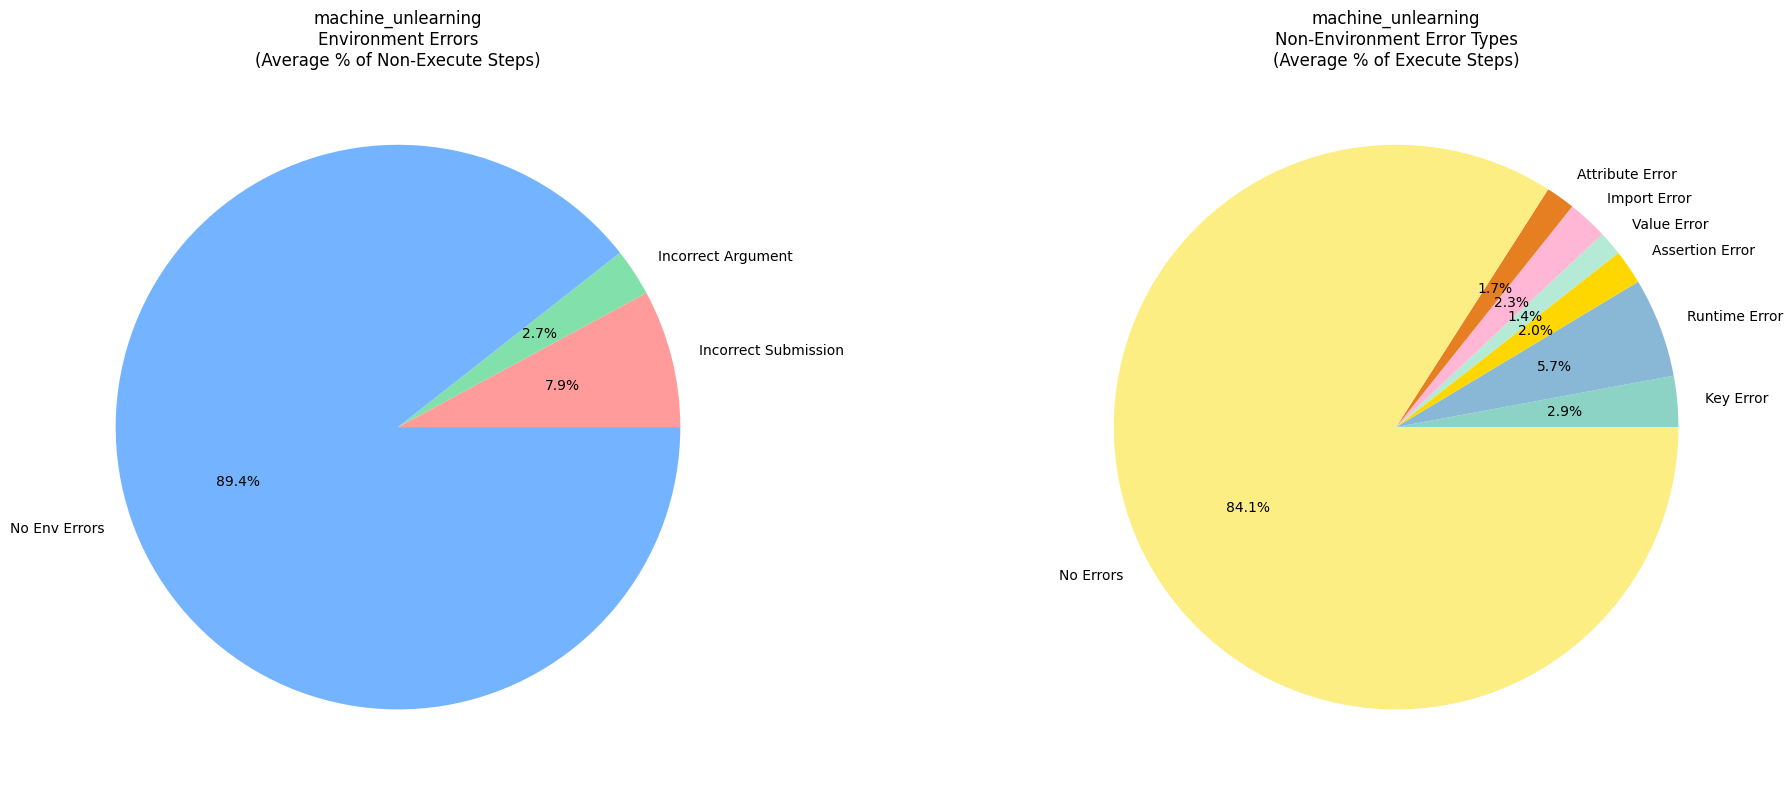

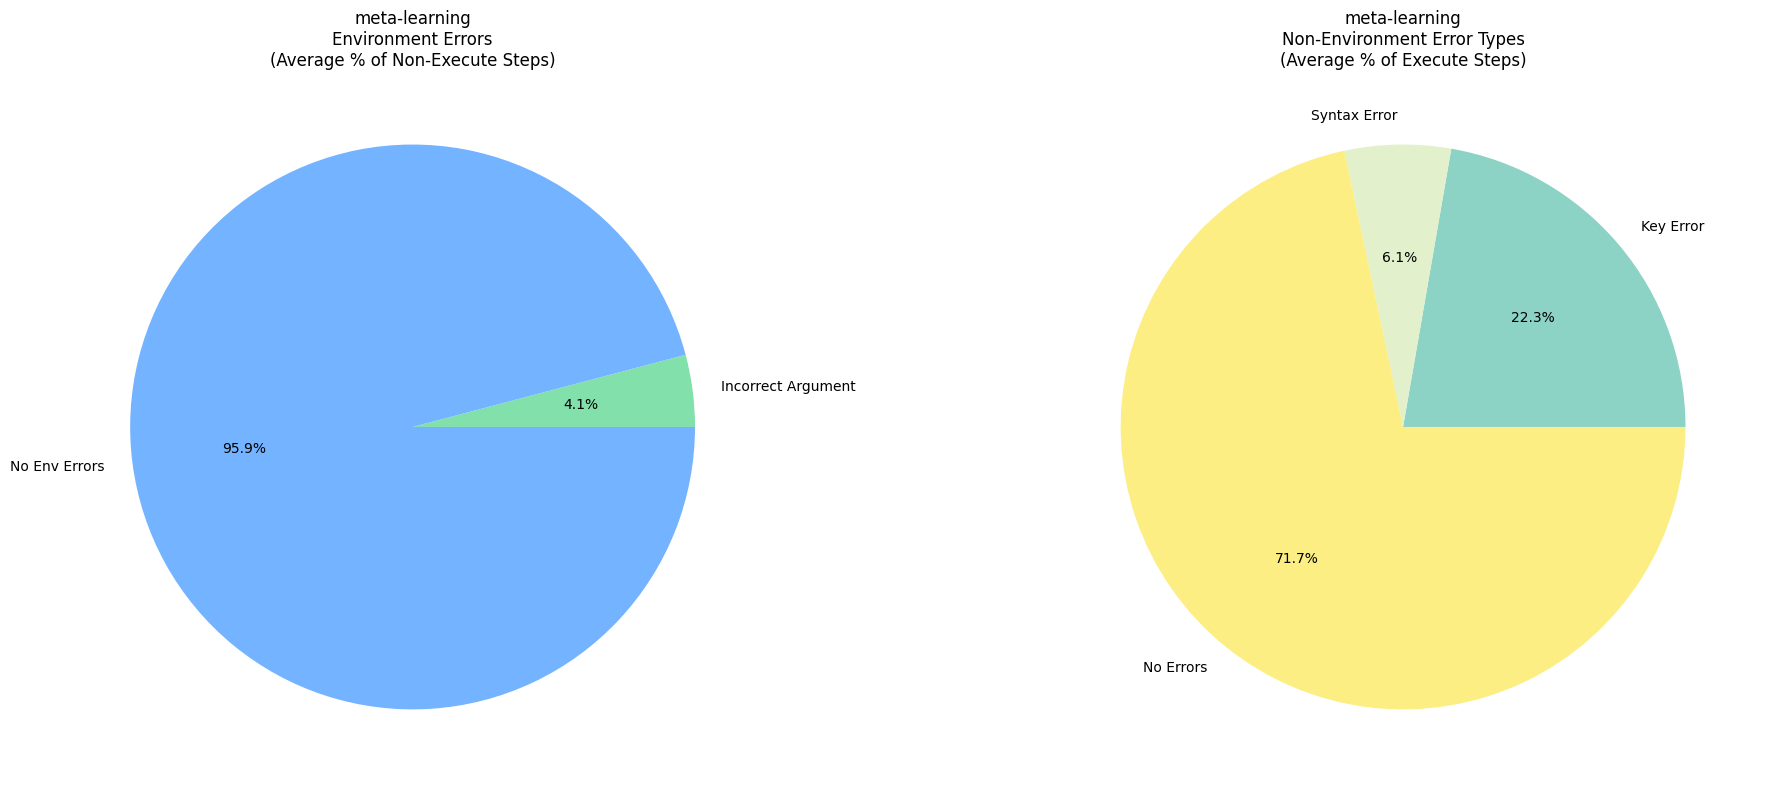

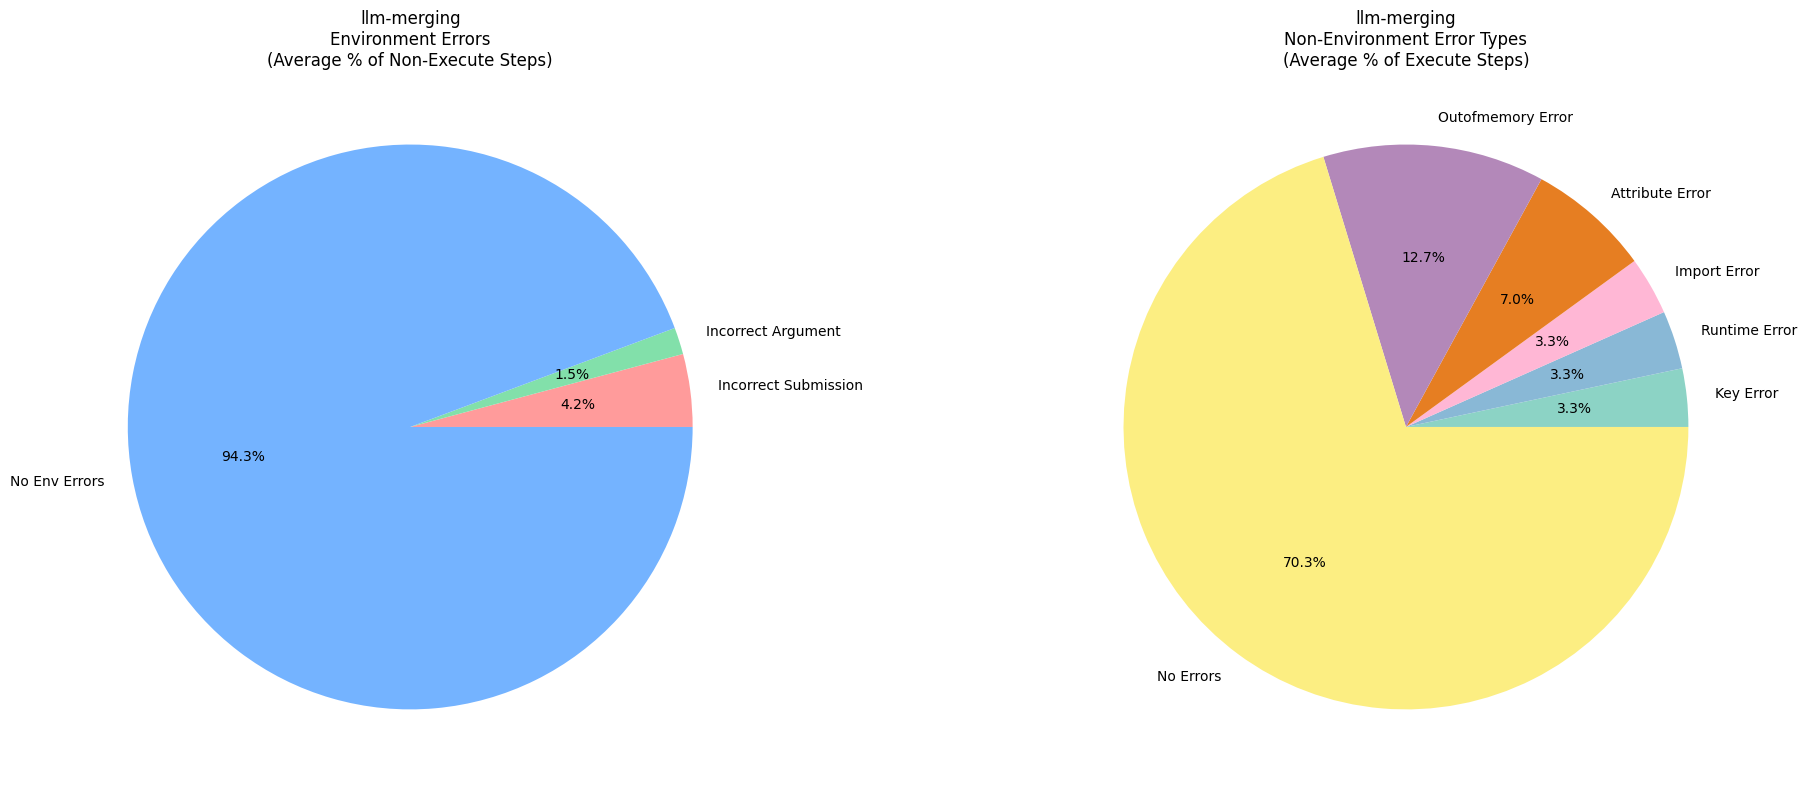

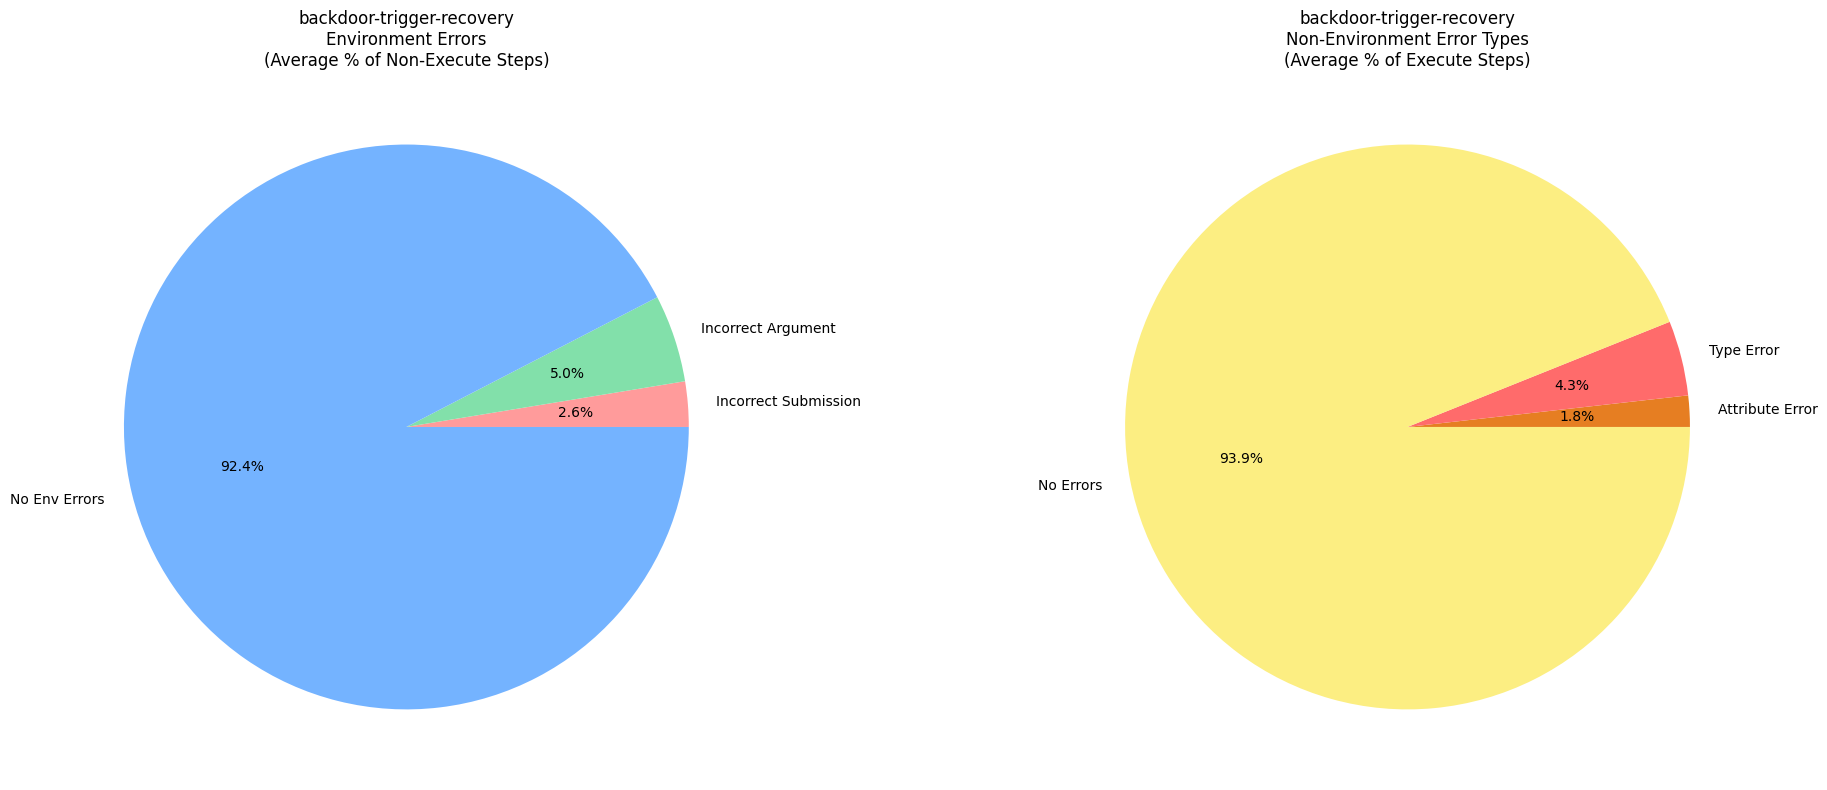

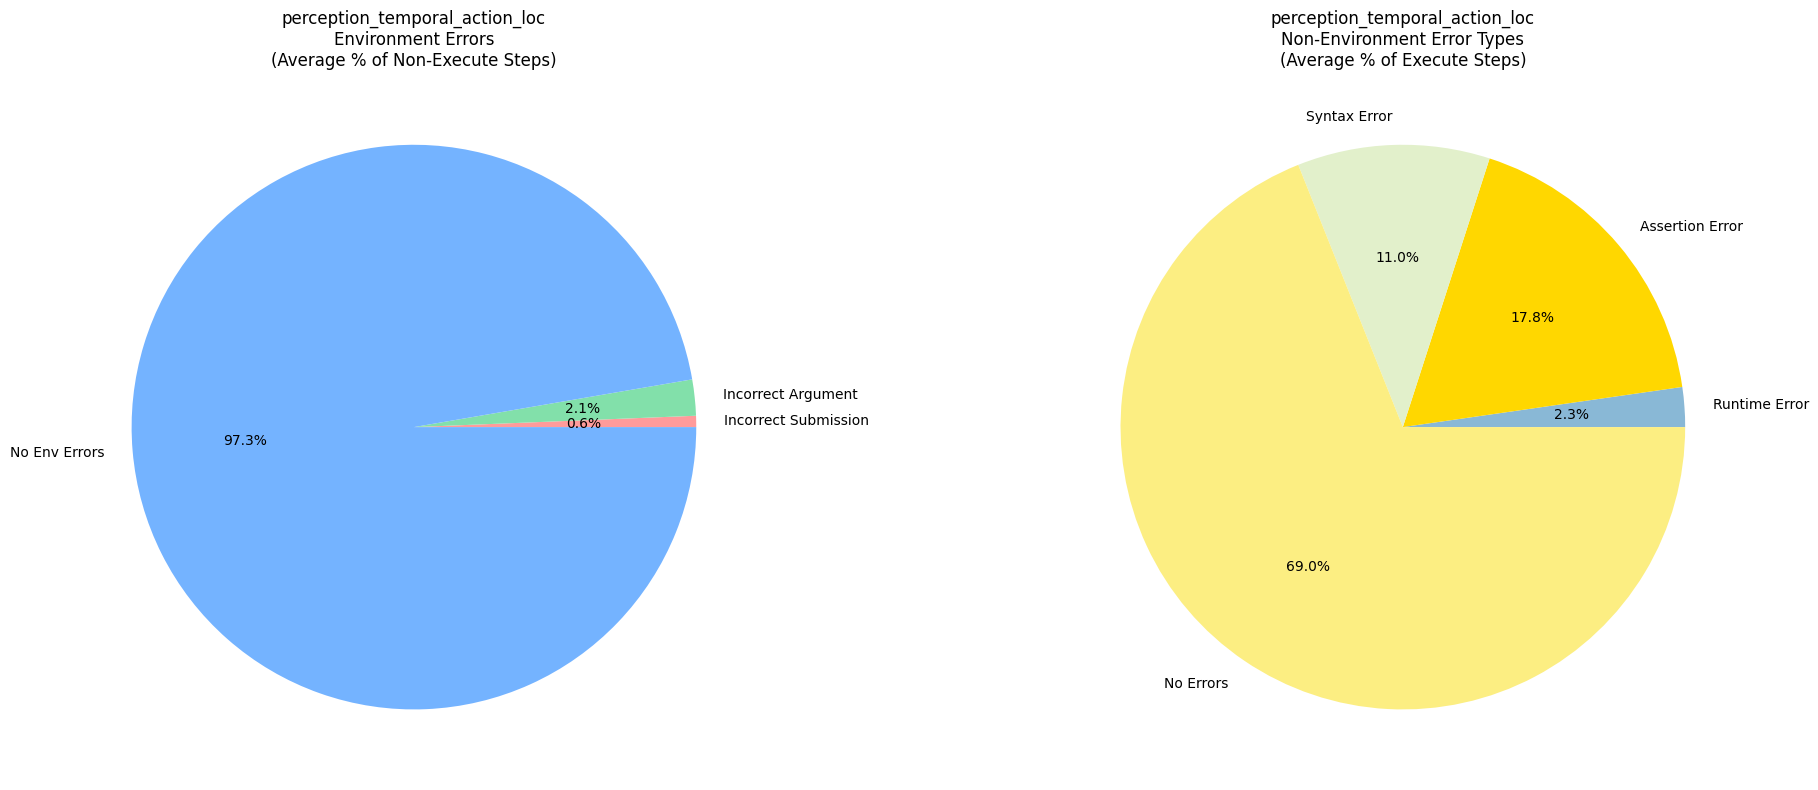

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Read the error analysis JSON
with open('error_analysis.json', 'r') as f:
    data = json.load(f)

# Define consistent colors for each error type
color_map = {
    # Environment Errors
    'incorrect_submission': '#FF9B9B',      # Bright salmon pink
    'incorrect_argument': '#82E0AA',        # Light green
    'no_env_errors': '#74B3FF',            # Light blue
    
    # Non-Environment Errors
    'outofmemoryerror': '#B388B9',         # Purple
    'attributeerror': '#E67E22',           # Orange
    'importerror': '#FFB7D5',              # Pink
    'runtimeerror': '#89B8D6',             # Blue-gray
    'keyerror': '#8CD3C5',                 # Mint green
    'syntaxerror': '#E2F0CB',              # Lime green
    'valueerror': '#B5EAD7',               # Mint
    'assertionerror': '#FFD700',           # Gold
    'typeerror': '#FF6B6B',                # Bright coral red
    'no_errors': '#fcee82'                 # Light yellow
}

error_types = [
    'keyerror', 'runtimeerror', 'assertionerror', 
    'valueerror', 'syntaxerror', 'importerror', 'attributeerror', 
    'outofmemoryerror', 'typeerror'
]

def categorize_error(observation):
    obs_lower = observation.lower()
    if 'enverror' in obs_lower:
        if "your submission didn't achieve a score of" in obs_lower:
            return 'incorrect_submission'
        return 'incorrect_argument'
    for error_type in error_types:
        if error_type in obs_lower:
            return error_type
    return None

def analyze_errors(task_data):
    iteration_stats = []
    
    for model in task_data.values():
        for iteration_data in model.values():
            non_execute_steps = iteration_data['non_execute_script_steps']
            execute_steps = iteration_data['execute_script_steps']
            
            # Initialize error counts for this iteration
            error_counts = {error_type: 0 for error_type in error_types}
            incorrect_submission_count = 0
            incorrect_argument_count = 0
            
            # Count each type of error
            for obs in iteration_data['error_observations']:
                error_type = categorize_error(obs['observation'])
                if error_type == 'incorrect_submission':
                    incorrect_submission_count += 1
                elif error_type == 'incorrect_argument':
                    incorrect_argument_count += 1
                elif error_type in error_types:
                    error_counts[error_type] += 1
            
            # Calculate percentages for this iteration
            total_env_count = incorrect_submission_count + incorrect_argument_count
            env_error_pct = (total_env_count / non_execute_steps * 100) if non_execute_steps > 0 else 0
            incorrect_submission_pct = (incorrect_submission_count / non_execute_steps * 100) if non_execute_steps > 0 else 0
            incorrect_argument_pct = (incorrect_argument_count / non_execute_steps * 100) if non_execute_steps > 0 else 0
            
            error_type_pcts = {
                error_type: (count / execute_steps * 100) if execute_steps > 0 else 0
                for error_type, count in error_counts.items()
            }
            
            iteration_stats.append({
                'incorrect_submission_count': incorrect_submission_count,
                'incorrect_argument_count': incorrect_argument_count,
                'incorrect_submission_pct': incorrect_submission_pct,
                'incorrect_argument_pct': incorrect_argument_pct,
                'error_type_counts': error_counts,
                'error_type_pcts': error_type_pcts,
                'non_execute_steps': non_execute_steps,
                'execute_steps': execute_steps
            })
    
    # Calculate average percentages across iterations
    avg_incorrect_submission = np.mean([stat['incorrect_submission_pct'] for stat in iteration_stats]) / 100
    avg_incorrect_argument = np.mean([stat['incorrect_argument_pct'] for stat in iteration_stats]) / 100
    avg_error_type_ratios = {
        error_type: np.mean([
            stat['error_type_pcts'][error_type] 
            for stat in iteration_stats
        ]) / 100
        for error_type in error_types
    }
    
    return iteration_stats, (avg_incorrect_submission, avg_incorrect_argument), avg_error_type_ratios

def create_pie_charts(task_name, env_ratios, error_type_ratios):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Environment Errors Pie Chart
    env_data = [
        env_ratios[0] * 100,  # Incorrect Submission
        env_ratios[1] * 100,  # Incorrect Argument
        (1 - sum(env_ratios)) * 100  # No Env Errors
    ]
    env_labels = ['Incorrect Submission', 'Incorrect Argument', 'No Env Errors']
    env_colors = [color_map['incorrect_submission'], 
                 color_map['incorrect_argument'],
                 color_map['no_env_errors']]
    
    # Filter out zero values for env errors
    non_zero_env = [(value, label, color) 
                    for value, label, color in zip(env_data, env_labels, env_colors) 
                    if value > 0]
    if non_zero_env:
        values, labels, colors = zip(*non_zero_env)
        ax1.pie(values, 
                labels=labels,
                autopct='%1.1f%%',
                colors=colors)
    ax1.set_title(f'{task_name}\nEnvironment Errors\n(Average % of Non-Execute Steps)')
    
    # Non-Environment Errors Detailed Pie Chart
    error_values = [ratio * 100 for ratio in error_type_ratios.values()]
    remaining = 100 - sum(error_values)
    
    # Combine all values and labels
    all_values = error_values + ([remaining] if remaining > 0 else [])
    all_labels = list(error_type_ratios.keys()) + (['No Errors'] if remaining > 0 else [])
    all_colors = [color_map[error_type] for error_type in error_type_ratios.keys()]
    if remaining > 0:
        all_colors.append(color_map['no_errors'])
    
    # Filter out zero values
    non_zero = [(value, label, color) 
                for value, label, color in zip(all_values, all_labels, all_colors) 
                if value > 0]
    if non_zero:
        values, labels, colors = zip(*non_zero)
        ax2.pie(values,
                labels=[label.replace('error', ' Error').title() for label in labels],
                autopct='%1.1f%%',
                colors=colors)
    ax2.set_title(f'{task_name}\nNon-Environment Error Types\n(Average % of Execute Steps)')
    
    plt.tight_layout()
    plt.show()

# Create pie charts for each task
for task_name, task_data in data.items():
    # Get statistics for all iterations
    iteration_stats, env_ratios, avg_error_type_ratios = analyze_errors(task_data)
    
    # Create pie charts for task average
    create_pie_charts(task_name, env_ratios, avg_error_type_ratios)
    
    # Print numerical summary
    # print(f"\nTask: {task_name}")
    # print("\nIteration Statistics:")
    # for i, stat in enumerate(iteration_stats, 1):
    #     print(f"\nIteration {i}:")
    #     print(f"  Execute Steps: {stat['execute_steps']}")
    #     print(f"  Non-Execute Steps: {stat['non_execute_steps']}")
    #     print(f"  Env Errors:")
    #     print(f"    Incorrect Submission: {stat['incorrect_submission_count']} ({stat['incorrect_submission_pct']:.1f}%) out of {stat['non_execute_steps']} non-execute steps")
    #     print(f"    Incorrect Argument: {stat['incorrect_argument_count']} ({stat['incorrect_argument_pct']:.1f}%) out of {stat['non_execute_steps']} non-execute steps")
    #     print("  Non-Env Errors:")
    #     for error_type, count in stat['error_type_counts'].items():
    #         if count > 0:  # Only print non-zero values
    #             pct = stat['error_type_pcts'][error_type]
    #             print(f"    {error_type.replace('error', ' Error').title()}: {count} ({pct:.1f}%) out of {stat['execute_steps']} execute steps")
    
    # print(f"\nAverages across iterations:")
    # print("  Env Errors:")
    # print(f"    Incorrect Submission: {env_ratios[0]*100:.1f}% of non-execute steps")
    # print(f"    Incorrect Argument: {env_ratios[1]*100:.1f}% of non-execute steps")
    # print("  Non-Env Errors:")
    # for error_type, ratio in avg_error_type_ratios.items():
    #     if ratio > 0:  # Only print non-zero values
    #         print(f"    {error_type.replace('error', ' Error').title()}: {ratio*100:.1f}% of execute steps")